### resources used
1. https://lpsa.swarthmore.edu/Systems/Electrical/mna/MNA5.html
2. https://spinningnumbers.org/assets/modified-nodal-analysis.pdf


In [14]:
import numpy as np

class Resistor:
    """Two-terminal resistor component"""
    def __init__(self, resistance):
        self.value = resistance
        self.p = None  
        self.n = None  
class Capacitor:
    def __init__(self, capacitance):
        self.value = capacitance
        self.p = None  
        self.n = None 
class VoltageSource:
    """Independent voltage source with specified DC voltage"""
    def __init__(self, voltage):
        self.value = voltage
        self.p = None  
        self.n = None  
class IdealOpAmp:
    """Ideal op amp with three terminals: V+, V-, and Vout"""
    def __init__(self):
        self.Vplus = None   
        self.Vminus = None  
        self.Vout = None    

class Circuit:
    """Circuit container that uses Modified Nodal Analysis (MNA) to solve for node voltages"""
    def __init__(self):
        self.components = []
        self.next_node_id = 1  # incremental node ID allocator (0 is reserved for ground)
        self.frequency = 0
    
    def setFrequency(self, omega):
        self.frequency = omega

    def addComponent(self, comp):
        self.components.append(comp)

    def connectComponents(self, comp1, term1, comp2, term2):
        """Connect a terminal of comp1 to a terminal of comp2 (or to a node/ground)."""
        # Helper 
        def get_node(comp, term):
            if comp is None or isinstance(comp, (int, float)):
                # connecting to a node (int) or ground (None/0)
                return 0 if comp is None else int(comp)
            if isinstance(comp, IdealOpAmp):
                if term in ('V+', 'Vp', 'v+', 'positive'):
                    return comp.Vplus
                elif term in ('V-', 'Vminus', 'v-', 'negative'):
                    return comp.Vminus
                elif term.lower() in ('vout', 'out'):
                    return comp.Vout
                else:
                    raise ValueError(f"Unknown op amp terminal '{term}'")
            else:
                # Two-terminal components (Resistor, VoltageSource, etc.)
                if term in ('p', 'pos', 'positive') or term in (1, '1'):
                    return comp.p
                elif term in ('n', 'neg', 'negative') or term in (2, '2'):
                    return comp.n
                else:
                    raise ValueError(f"Unknown component terminal '{term}'")

        # Helper to set a component terminal to a given node ID
        def set_node(comp, term, node_id):
            if isinstance(comp, IdealOpAmp):
                if term in ('V+', 'Vp', 'v+', 'positive'):
                    comp.Vplus = node_id
                elif term in ('V-', 'Vminus', 'v-', 'negative'):
                    comp.Vminus = node_id
                elif term.lower() in ('vout', 'out'):
                    comp.Vout = node_id
            else:
                if term in ('p', 'pos', 'positive') or term in (1, '1'):
                    comp.p = node_id
                elif term in ('n', 'neg', 'negative') or term in (2, '2'):
                    comp.n = node_id

        # Determine node IDs 
        node1 = get_node(comp1, term1)
        node2 = get_node(comp2, term2)
        # If neither side has a node, assign a new node ID
        if node1 is None and node2 is None:
            node_new = self.next_node_id
            self.next_node_id += 1
            node1 = node_new
            node2 = node_new
        elif node1 is None:
            node1 = node2
        elif node2 is None:
            node2 = node1
        # else merge
        elif node1 != node2:
        
            replace_id = node2
            keep_id = node1
            for comp in self.components:
                if isinstance(comp, IdealOpAmp):
                    if comp.Vplus == replace_id: comp.Vplus = keep_id
                    if comp.Vminus == replace_id: comp.Vminus = keep_id
                    if comp.Vout == replace_id: comp.Vout = keep_id
                else:
                    if comp.p == replace_id: comp.p = keep_id
                    if comp.n == replace_id: comp.n = keep_id
            node2 = node1 = keep_id

        # Set the determined node IDs on the component terminals
        if comp1 is not None and not isinstance(comp1, (int, float)):
            set_node(comp1, term1, node1)
        if comp2 is not None and not isinstance(comp2, (int, float)):
            set_node(comp2, term2, node2)

    def solveSystem(self):
        """uses mna to return dict of voltages."""
        # get node ids
        node_ids = set()
        for comp in self.components:
            if isinstance(comp, IdealOpAmp):
                # Include op amp terminals
                if comp.Vplus is not None: node_ids.add(comp.Vplus)
                if comp.Vminus is not None: node_ids.add(comp.Vminus)
                if comp.Vout is not None: node_ids.add(comp.Vout)
            else:
                if comp.p is not None: node_ids.add(comp.p)
                if comp.n is not None: node_ids.add(comp.n)
        node_ids.discard(0)  # remove ground
        node_list = sorted(node_ids)
        N = len(node_list)  # number of non-ground nodes
        node_index = {nid: i for i, nid in enumerate(node_list)}

        # MNA matrices
        G = np.zeros((N, N), dtype=complex)        # conductance matrix
        I = np.zeros(N,dtype=complex)            # current injection vector
        B = np.zeros((N, 0),dtype=complex)       # independent current sources
        E = np.array([],dtype=complex)           # voltage source vector 
        
        # handle resistors
        for comp in self.components:
            if isinstance(comp, Resistor):
                a = comp.p or 0
                b = comp.n or 0
                if a == 0 and b == 0:
                    continue  
                g_val = 1.0 / comp.value if comp.value != 0 else 1e9  # very large resistor is a billion
                if a != 0:
                    G[node_index[a], node_index[a]] += g_val
                if b != 0:
                    G[node_index[b], node_index[b]] += g_val
                if a != 0 and b != 0:
                    G[node_index[a], node_index[b]] -= g_val
                    G[node_index[b], node_index[a]] -= g_val
            
            if isinstance(comp, Capacitor):
                g_val = 1j * self.frequency * comp.value 
                a = comp.p or 0
                b = comp.n or 0
                if a == 0 and b == 0:
                    continue  
                #g_val = 1.0 / comp.value if comp.value != 0 else 1e9  # very large resistor is a billion
                if a != 0:
                    G[node_index[a], node_index[a]] += g_val
                if b != 0:
                    G[node_index[b], node_index[b]] += g_val
                if a != 0 and b != 0:
                    G[node_index[a], node_index[b]] -= g_val
                    G[node_index[b], node_index[a]] -= g_val

        # extra rows for voltages
        voltage_sources = [comp for comp in self.components if isinstance(comp, VoltageSource)]
        M = len(voltage_sources)
        if M > 0:
            B = np.zeros((N, M))
            E = np.zeros(M)
        for j, src in enumerate(voltage_sources):
            a = src.p or 0
            b = src.n or 0
            # KCL: add source current leaving 'a' and entering 'b'
            if a != 0:
                B[node_index[a], j] += 1
            if b != 0:
                B[node_index[b], j] -= 1
            # Voltage constraint: Va - Vb = value
            if a != 0:
                pass
            if b != 0:
                pass
            E[j] = src.value


        A_top = np.hstack((G, B))
        opamps = [comp for comp in self.components if isinstance(comp, IdealOpAmp)]
        P = len(opamps)
        total_constraints = M + P
        if total_constraints > 0:
            C = np.zeros((total_constraints, N))
            # Fill in voltage source KVL rows (first M rows of C and E)
            for j, src in enumerate(voltage_sources):
                a = src.p or 0
                b = src.n or 0
                if a != 0:
                    C[j, node_index[a]] = 1
                if b != 0:
                    C[j, node_index[b]] = -1
                # E[j] is already set to source voltage
            # Fill in ideal op amp constraint rows: V+ - V- = 0  (for each op amp)
            for k, op in enumerate(opamps, start=M):
                a = op.Vplus or 0
                b = op.Vminus or 0
                # Only add if both terminals are defined (else it's floating or trivial)
                if a != 0 and b != 0:
                    C[k, node_index[a]] = 1
                    C[k, node_index[b]] = -1
                    # Constraint value = 0 (already default in E if extended)
                elif a != 0 or b != 0:
                    # If one input is grounded, enforce the other equals 0 (ground)
                    nid = a if b == 0 else b
                    C[k, node_index[nid]] = 1
                    # value 0
            # Extend E for op amp constraints (zeros for those rows)
            if P > 0:
                if E.size == 0:
                    E = np.zeros(total_constraints)
                else:
                    E = np.concatenate((E, np.zeros(P)))
        else:
            # No constraints (no op amp or voltage source)
            C = np.zeros((0, N),dtype=complex)
            E = np.zeros(0,dtype=complex)

        # Remove KCL equations for op amp output nodes (output can source/sink any current)
        # We do this by removing the row corresponding to each op amp output from A_top and I (KCL equations)
        rows_to_remove = []
        for op in opamps:
            if op.Vout is not None and op.Vout in node_index:
                rows_to_remove.append(node_index[op.Vout])

        for r in sorted(rows_to_remove, reverse=True):
            A_top = np.delete(A_top, r, axis=0)   # drop KCL row
            I     = np.delete(I,     r)           # drop matching entry in RHS

        # Assemble full augmented matrix:
        A_bottom = np.hstack((C, np.zeros((C.shape[0], B.shape[1]))), dtype=complex)
        

        A = np.vstack((A_top, A_bottom),dtype=complex)
        # Assemble full right-hand side vector (currents and voltages)
        b_top = I  # KCL current injections (I is zero here as we have no independent current sources defined)
        b_bottom = E
        b = np.concatenate((b_top, b_bottom))
        # Solve the linear system A x = b for unknown node voltages and source currents
        solution = np.linalg.lstsq(A, b, rcond=None)[0]
        num_nodes = len(node_list)
        # Extract node voltages from solution vector
        node_voltages = {0: 0.0}
        for nid, idx in node_index.items():
            node_voltages[nid] = solution[idx]
        return node_voltages


circ = Circuit()
circ.setFrequency(1000)
Vin  = VoltageSource(5.0)      
op   = IdealOpAmp()
R1   = Resistor(10000.0)       
R2   = Resistor(1000.0)       

for c in (Vin, op, R1, R2):
    circ.addComponent(c)


circ.connectComponents(Vin, 'p',  op,  'V+')   
circ.connectComponents(Vin, 'n',  None, None) 
circ.connectComponents(op,  'Vout', R1,  'p')  
circ.connectComponents(R1,  'n',   op,  'V-')  
circ.connectComponents(op,  'V-',  R2,  'p')   
circ.connectComponents(R2,  'n',   None, None) 

#
voltages = circ.solveSystem()
print(f"Op‑amp output   Vout = {voltages[op.Vout]:.3f} V")


Op‑amp output   Vout = 55.000+0.000j V


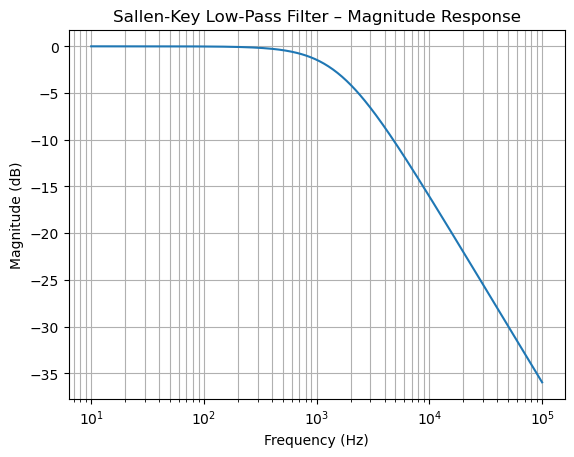

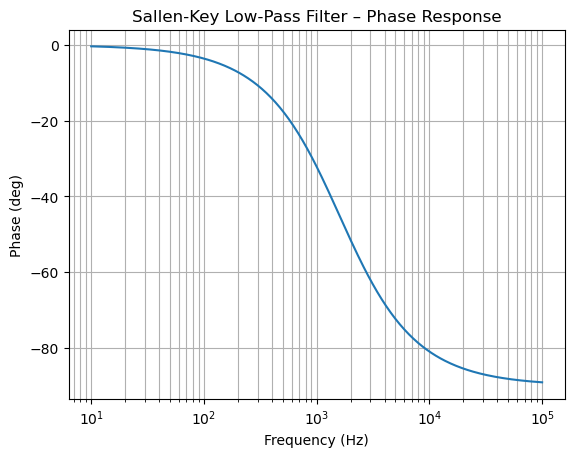

In [28]:

import numpy as np
import matplotlib.pyplot as plt
circ = Circuit()

Vin = VoltageSource(1.0)  
op  = IdealOpAmp()
R1  = Resistor(10e3)
R2  = Resistor(10e3)

C1  = Capacitor(10e-9)
C2  = Capacitor(10e-9)

for c in (Vin, op, R1, R2, C1, C2):
    circ.addComponent(c)


circ.connectComponents(Vin, 'p', R1, 'n')
circ.connectComponents(Vin, 'n', None, None)    
circ.connectComponents(R1, 'p', R2, 'n')         
circ.connectComponents(R2, 'p', C2, 'p')        
circ.connectComponents(C2, 'n', None, None)      
circ.connectComponents(R2, 'n', op, 'V+')     
circ.connectComponents(R2, 'n', C1, 'n')       
circ.connectComponents(C2, 'p', op, 'Vout')      
circ.connectComponents(op, 'V-', op, 'Vout') 


f = np.logspace(1, 5, 400)           
mag = np.zeros_like(f, dtype=float)
phase = np.zeros_like(f, dtype=float)

for i, freq in enumerate(f):
    omega = 2 * np.pi * freq
    circ.setFrequency(omega)
    V = circ.solveSystem()
    Vout = V[op.Vout]
    mag[i] = 20 * np.log10(np.abs(Vout))
    phase[i] = np.angle(Vout, deg=True)


plt.figure()
plt.semilogx(f, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Sallen‑Key Low‑Pass Filter – Magnitude Response")
plt.grid(True, which='both')


plt.figure()
plt.semilogx(f, phase)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (deg)")
plt.title("Sallen‑Key Low‑Pass Filter – Phase Response")
plt.grid(True, which='both')
plt.show()